In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pvlib import pvsystem, modelchain, location
from scipy.optimize import curve_fit
from scipy.integrate import trapz
from random import choice, randint, seed

C:\Users\denni\AppData\Local\Temp\ipykernel_26416\1987723736.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
def load_weather_data(file_path):
    """ Load historical weather data from a CSV file. """

    return pd.read_csv(file_path)

def get_pv_system():
    """ Retrieves and configures a PVSystem object based on the panel type and parameters. """
    
    # Define the panel specifics and array configuration
    north_panel_specs = {'length': 1, 'width': 1.65, 'efficiency': 0.15, 'num_panels': 13}
    south_panel_specs = {'length': 1, 'width': 1.95, 'efficiency': 0.22, 'num_panels': 16}

    # Common array kwargs, excluding module_parameters to avoid conflict
    array_kwargs = dict(
        temperature_model_parameters=dict(a=-3.56, b=-0.075, deltaT=3)
    )

    # Define arrays based on orientation and panel specs
    arrays = [
        pvsystem.Array(
            mount=pvsystem.FixedMount(41.7, 0),  # North facing, azimuth=0 degrees
            name='North-Facing Array',
            module_parameters={'pdc0': north_panel_specs['num_panels'] * north_panel_specs['length'] * north_panel_specs['width'] * north_panel_specs['efficiency'] *1000 , 'gamma_pdc': -0.004},
            **array_kwargs
        ),
        pvsystem.Array(
            mount=pvsystem.FixedMount(41.7, 180),  # South facing, azimuth=180 degrees
            name='South-Facing Array',
            module_parameters={'pdc0': south_panel_specs['num_panels'] * south_panel_specs['length'] * south_panel_specs['width'] * south_panel_specs['efficiency'] * 1000 , 'gamma_pdc': -0.004},
            **array_kwargs
        )
    ]

    # Define the PV system with the arrays
    system = pvsystem.PVSystem(arrays=arrays, inverter_parameters=dict(pdc0=3200))
    return system


def simulate_pv_output(system, weather_data, location):
    """ Simulate daily PV output for all arrays in the system. """

    # Create the ModelChain object
    mc = modelchain.ModelChain(system, location, aoi_model='physical', spectral_model='no_loss')


    # Run the model
    weather_data.rename(columns={'Q':'ghi'}, inplace=True)
    mc.run_model(weather_data)
    # Save the results to DataFrames
    dc_output = pd.DataFrame({array.name: output for array, output in zip(system.arrays, mc.results.dc)}, index=weather_data.index)
    ac_output = pd.DataFrame(mc.results.ac, index=weather_data.index)
   
    # Optional: Combine DC and AC outputs into one DataFrame for easier handling or analysis
    combined_output = pd.concat([dc_output, ac_output], axis=1)
    
    return combined_output

# Define the Gaussian function
def gaussian(x, a, b, c):
    return a * np.exp(-((x - b) ** 2) / (2 * c ** 2))

# Function to fit Gaussian to daily data
def fit_gaussian_to_daily_data(daily_data):
    x_numeric = np.arange(len(daily_data))
    try:
        popt, _ = curve_fit(gaussian, x_numeric, daily_data, p0=[max(daily_data), np.argmax(daily_data), 1])
    except RuntimeError:
        popt = [0, 0, 1]  # Fallback values in case fit fails
    return popt

def plot_energy_outputs(data, energy_outputs, startday, days_to_plot=3):
    plt.figure(figsize=(12, 8))

    for day in range(startday, startday+days_to_plot):
        start_idx = day * 24
        end_idx = (day + 1) * 24

        if end_idx > len(energy_outputs):
            end_idx = len(energy_outputs)  # Prevent indexing beyond the data

        daily_data = energy_outputs[start_idx:end_idx]

        popt = fit_gaussian_to_daily_data(daily_data)
        x_dense = np.linspace(0, 23, 500)
        gaussian_curve = gaussian(x_dense, *popt)
        x_plot = pd.date_range(start=energy_outputs.index[start_idx], periods=24, freq='H')
        x_plot_dense = pd.date_range(start=x_plot[0], end=x_plot[-1], periods=500)

        # Plot Gaussian fit
        plt.plot(x_plot_dense, gaussian_curve, label=f'Gaussian Fit Day {day+1}', linewidth=2)

        # Plot daily data
        plt.plot(x_plot, daily_data, label=f'Sandia Data Day {day+1}', linestyle='--')

    # Plot 'W.mean_value' from data DataFrame
    plt.plot(data.index[startday * 24:(startday+days_to_plot) * 24], data['W.mean_value'][startday * 24:(startday+days_to_plot) * 24], 
             color='black', label='Mean W data', linewidth=2, linestyle='-.')

    plt.title('Energy Output and Gaussian Fits')
    plt.xlabel('Time')
    plt.ylabel('Energy Output (Wh)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()


C:\Users\denni\AppData\Local\Temp\ipykernel_26416\4250220188.py:86: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  x_plot = pd.date_range(start=energy_outputs.index[start_idx], periods=24, freq='H')


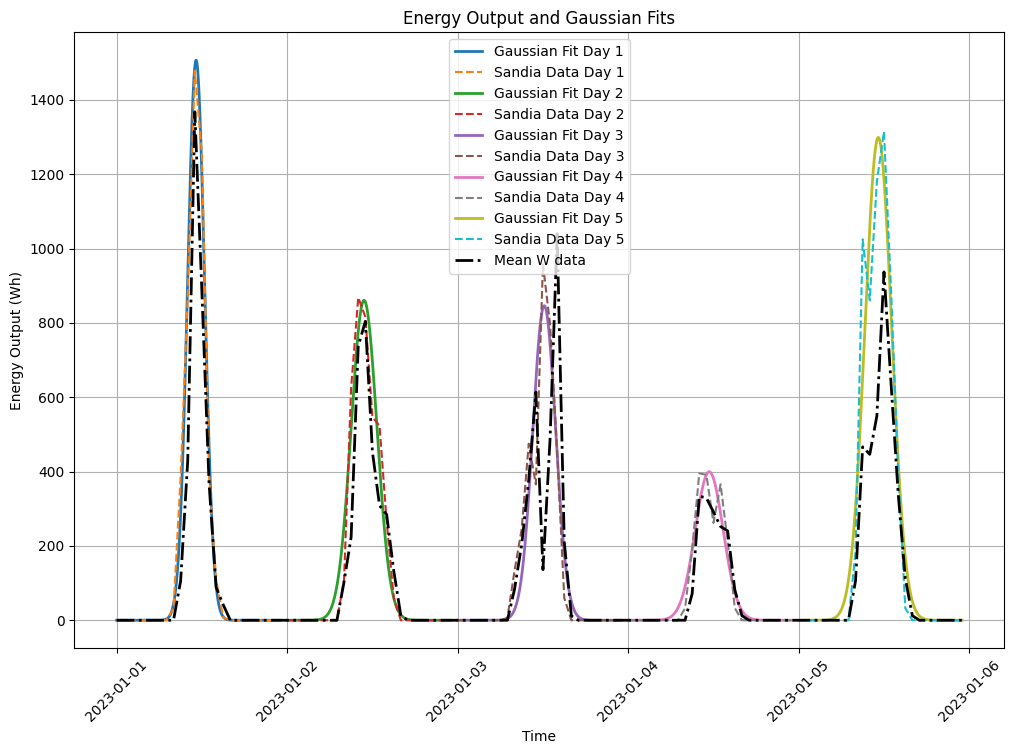

In [4]:
# Load in weather data
weather_data = load_weather_data('energy_data/result.csv')
weather_data.index = pd.to_datetime(weather_data['time'], utc=True)

# Define location and height of Vertigo building TUe 
site_location = location.Location(51.4463868639624, 5.485053067432616, altitude=58, tz='Europe/Amsterdam')
system = get_pv_system()
energy_outputs = simulate_pv_output(system, weather_data, site_location)

# Plot energy outputs
plot_energy_outputs(weather_data, energy_outputs['p_mp'], 60, 4) 


In [51]:
def prepare_data_for_model(energy_outputs, weather_data):
    model_data = []

    # Process data day by day
    for day in range(365):  # Assuming you have a full year of data
        start_idx = day * 24
        end_idx = (day + 1) * 24

        # Extract daily weather data and energy outputs
        daily_weather = weather_data.iloc[start_idx:end_idx]
        daily_data = energy_outputs['p_mp'][start_idx:end_idx]

        # Fit Gaussian to daily energy data
        popt = fit_gaussian_to_daily_data(daily_data)

        if popt is not None:
            row = {
                # Store sequences as lists in the DataFrame cell
                'temperature_sequence': daily_weather['T'].tolist(),
                'wind_speed_sequence': daily_weather['FH'].tolist(),
                'dni_sequence': daily_weather['dni'].tolist(),
                'dhi_sequence': daily_weather['dhi'].tolist(),
                'global_irradiance_sequence': daily_weather['ghi'].tolist(),
                'gaussian': popt.tolist()
            }
            model_data.append(row)

    return pd.DataFrame(model_data)

In [54]:
prepared_data = prepare_data_for_model(energy_outputs, weather_data)
prepared_data.to_csv('energy_data/model_input.csv', index=False)

time
2023-01-01 00:00:00+00:00    0.0
2023-01-01 01:00:00+00:00    0.0
2023-01-01 02:00:00+00:00    0.0
2023-01-01 03:00:00+00:00    0.0
2023-01-01 04:00:00+00:00    0.0
                            ... 
2023-01-15 19:00:00+00:00    0.0
2023-01-15 20:00:00+00:00    0.0
2023-01-15 21:00:00+00:00    0.0
2023-01-15 22:00:00+00:00    0.0
2023-01-15 23:00:00+00:00    0.0
Name: p_mp, Length: 360, dtype: float64


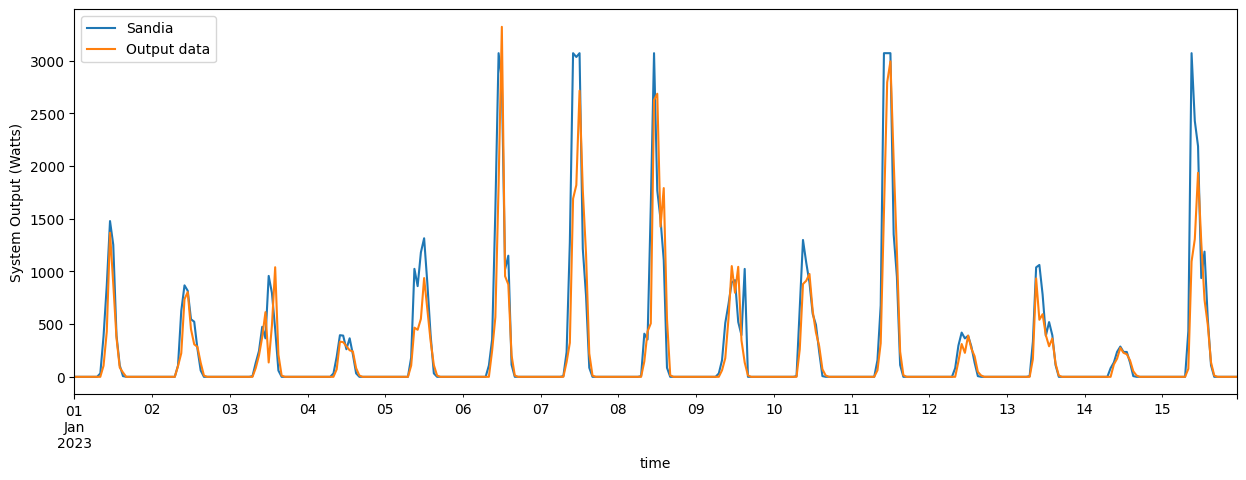

In [5]:
startdate = '2023-01-01'
enddate = '2023-01-15'

fig, ax = plt.subplots(figsize=(15,5))

weather_days = weather_data['W.mean_value'][startdate:enddate]
output_days = energy_outputs['p_mp'][startdate:enddate]
print(output_days)
output_days.plot(label='Sandia')
weather_days.plot(label = 'Output data')

plt.ylabel('System Output (Watts)')
plt.legend()
plt.show()

In [10]:
weather_days = weather_data['W.mean_value']
output_days = energy_outputs['p_mp']

# Calculate the area under the Gaussian curve
area_gaussian = trapz(weather_days, dx=1)

# Calculate the area under the original daily mean data
area_original = trapz(output_days, dx=1) 

# Calculate the difference in areas
area_difference =  area_gaussian/ area_original
print(np.mean(area_difference))

1.068519769854828


C:\Users\denni\AppData\Local\Temp\ipykernel_26416\2237669250.py:5: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  area_gaussian = trapz(weather_days, dx=1)
C:\Users\denni\AppData\Local\Temp\ipykernel_26416\2237669250.py:8: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  area_original = trapz(output_days, dx=1)


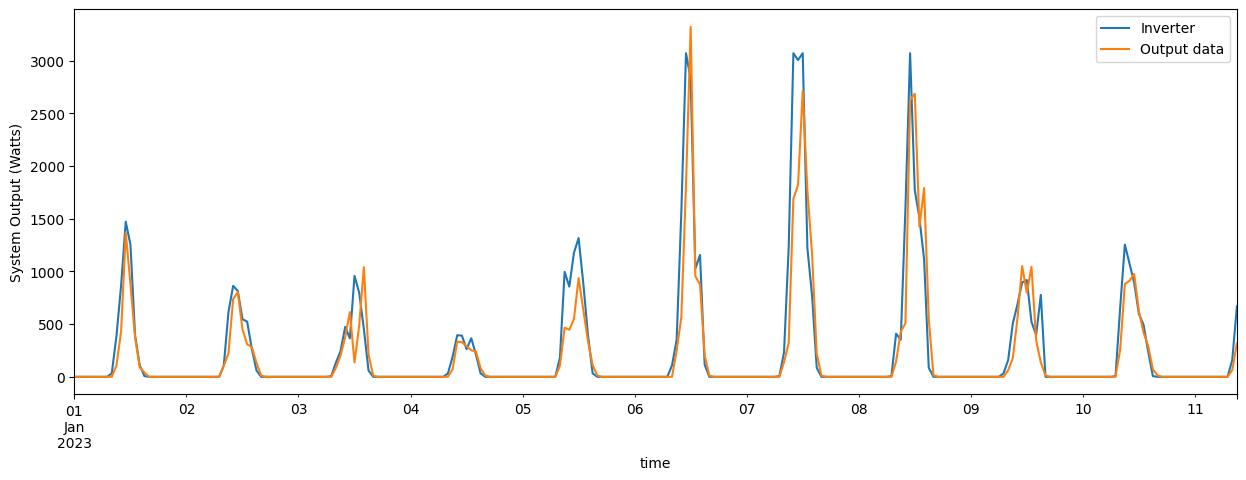

In [7]:
# TEST WITH DATA VERTIGO
# Define the panel specifics and array configuration
north_panel_specs = {'length': 1, 'width': 1.65, 'efficiency': 0.15, 'num_panels': 13}
south_panel_specs = {'length': 1, 'width': 1.95, 'efficiency': 0.22, 'num_panels': 16}

# Common array kwargs, excluding module_parameters to avoid conflict
array_kwargs = dict(
    temperature_model_parameters=dict(a=-3.56, b=-0.075, deltaT=3)
)

# Define arrays based on orientation and panel specs
arrays = [
    pvsystem.Array(
        mount=pvsystem.FixedMount(41.7, 0),  # North facing, azimuth=0 degrees
        name='North-Facing Array',
        module_parameters={'pdc0': north_panel_specs['num_panels'] * north_panel_specs['length'] * north_panel_specs['width'] * north_panel_specs['efficiency'] *1000 , 'gamma_pdc': -0.004},
        **array_kwargs
    ),
    pvsystem.Array(
        mount=pvsystem.FixedMount(41.7, 180),  # South facing, azimuth=180 degrees
        name='South-Facing Array',
        module_parameters={'pdc0': south_panel_specs['num_panels'] * south_panel_specs['length'] * south_panel_specs['width'] * south_panel_specs['efficiency'] * 1000 , 'gamma_pdc': -0.004},
        **array_kwargs
    )
]

# Location of Vertigo Building TUe
loc = location.Location(51.44641247252185, 5.485149827756224)  # Latitude, Longitude

# Define the PV system with the arrays
system = pvsystem.PVSystem(arrays=arrays, inverter_parameters=dict(pdc0=3200))

# Create the ModelChain object
mc = modelchain.ModelChain(system, loc, aoi_model='physical', spectral_model='no_loss')


# Run the model
weather_data.rename(columns={'Q':'ghi'}, inplace=True)
mc.run_model(weather_data.head(250))

# Plot the results
fig, ax = plt.subplots(figsize=(15,5))

#for array, pdc in zip(system.arrays, mc.results.dc):
    #pdc.plot(label=f'{array.name}')
mc.results.ac.plot(label='Inverter')
hoi = weather_data['W.mean_value'].head(250)
hoi.plot(label = 'Output data')

plt.ylabel('System Output (Watts)')
plt.legend()
plt.show()


In [8]:
import pvlib
modules = pvlib.pvsystem.retrieve_sam('SandiaMod')